In [60]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [61]:
test_dir = 'FastFood/Test/'
train_dir = 'FastFood/Train/'

In [62]:
# Collecte the class names.
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Print
print("No. Classes : {}".format(n_classes))
print("Classes     : {}".format(class_names))

No. Classes : 10
Classes     : ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']


In [73]:
from tensorflow.keras.applications.xception import Xception

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False

model = models.Sequential()
model.add(keras.Input(shape=(150, 150, 3)))
model.add(base_model)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax', kernel_initializer='zeros'))

83683744/83683744 [==============================] - 8s 0us/step


In [74]:
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.003)

model.compile(loss=loss,\
             optimizer=optimizer,\
             metrics=['acc'])

In [75]:
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True, vertical_flip=False)
valid_gen = ImageDataGenerator(rescale=1./255)

In [76]:
train_ds = train_gen.flow_from_directory(train_dir,  batch_size=256, target_size=(128,128))
test_ds = valid_gen.flow_from_directory(test_dir,  batch_size=256, target_size=(128,128))

Found 15000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [77]:
train_ds.class_indices


{'Baked Potato': 0,
 'Burger': 1,
 'Crispy Chicken': 2,
 'Donut': 3,
 'Fries': 4,
 'Hot Dog': 5,
 'Pizza': 6,
 'Sandwich': 7,
 'Taco': 8,
 'Taquito': 9}

In [79]:
history = model.fit(
    train_ds,
    epochs=2,
    validation_data=test_ds,
    #verbose=2
)

Epoch 1/2
38/59 [==================>...........] - ETA: 54s - loss: 1.1626 - acc: 0.6233

c:\Users\user\.virtualenvs\Capstone_1-1Zn1mtGM\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


59/59 [==============================] - 171s 3s/step - loss: 1.1125 - acc: 0.6403 - val_loss: 0.9166 - val_acc: 0.7047
Epoch 2/2
59/59 [==============================] - 173s 3s/step - loss: 0.9066 - acc: 0.7073 - val_loss: 0.8552 - val_acc: 0.7287


In [80]:
acc = history.history['acc']
val_acc= history.history['val_acc']
loss = history.history['loss']
val_loss= history.history['val_loss']

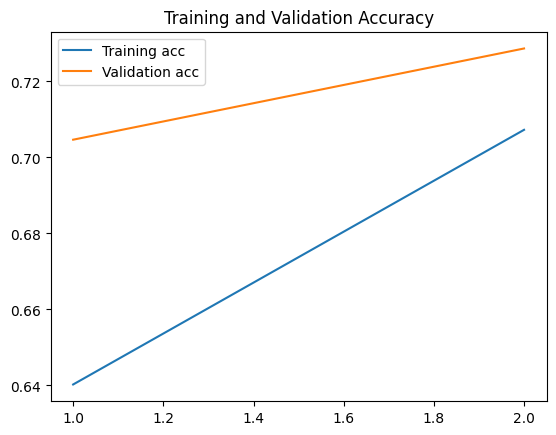

In [81]:

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')

plt.title('Training and Validation Accuracy')
plt.legend()
